In [1]:
# !pip install tensorflow>=2.2
# !pip install keras

In [25]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
import tensorflow
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Read the dataset...
messages = pd.read_csv('/content/sample_data/spam.csv', encoding='latin-1')
messages = messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

In [5]:
print('Head of the Datset is : ')
messages.head()

Head of the Datset is : 


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
print("Shape of the dataset is : ", messages.shape)
print("Distribution of the labels is : ")
messages['label'].value_counts()

Shape of the dataset is :  (5572, 2)
Distribution of the labels is : 


ham     4825
spam     747
Name: label, dtype: int64

In [11]:
print("Columns of the dataset are : ", messages.columns)

Columns of the dataset are :  Index(['label', 'text'], dtype='object')


In [12]:
# Get the labels...
labels = np.where(messages['label'] == 'spam',1,0)

In [13]:
# Split the dataset...
X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

## Preprocess the text

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
# Use the tokenizer to convert the list of training sets into integers...
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [20]:
print(X_train_seq[0])
print(X_test_seq[0])

[47, 25, 1273, 187]
[1042]


In [21]:
# Pad the sequences so that all sequences are of same length...
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [24]:
# Have a look at the padded sequences...
print("Padded Sequence for one of the text message is : ")
X_train_seq_padded[0]

Padded Sequence for one of the text message is : 


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   47,   25, 1273,  187], dtype=int32)

## Build the Model

In [40]:
# Prepare the model metrics...
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
    recall_score = true_positives / (possible_positives + K.epsilon())

    return recall_score

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_true,0,1)))
    precision_score = true_positives / (predicted_positives + K.epsilon())

    return precision_score


In [41]:
# Construct a Simple RNN Model
modelRNN = Sequential()

# create different types of Embeddings...
modelRNN.add(Embedding(len(tokenizer.index_word)+1, 32))
modelRNN.add(LSTM(32, dropout=0, recurrent_dropout=0))
modelRNN.add(Dense(32, activation='relu'))
modelRNN.add(Dense(1, activation='sigmoid'))
modelRNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          255104    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 264,513
Trainable params: 264,513
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compile the model...
modelRNN.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy', precision_m, recall_m])

In [43]:
# define the parameters for fitting the model...
batchSize = 32
epochs = 10

modelFit = modelRNN.fit(X_train_seq_padded, y_train,
                        batch_size=batchSize, epochs=epochs,
                        validation_data = (X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 8s 29ms/step - loss: 0.4070 - accuracy: 0.8725 - precision_m: 0.1660 - recall_m: 0.1660 - val_loss: 0.0698 - val_accuracy: 0.9803 - val_precision_m: 0.8800 - val_recall_m: 0.8800
Epoch 2/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0359 - accuracy: 0.9911 - precision_m: 0.9329 - recall_m: 0.9329 - val_loss: 0.0557 - val_accuracy: 0.9839 - val_precision_m: 0.9062 - val_recall_m: 0.9062
Epoch 3/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0107 - accuracy: 0.9972 - precision_m: 0.9508 - recall_m: 0.9508 - val_loss: 0.0607 - val_accuracy: 0.9848 - val_precision_m: 0.9062 - val_recall_m: 0.9062
Epoch 4/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0041 - accuracy: 0.9990 - precision_m: 0.9878 - recall_m: 0.9878 - val_loss: 0.0592 - val_accuracy: 0.9857 - val_precision_m: 0.9148 - val_recall_m: 0.9148
Epoch 5/10
140/140 [==============================] - 3s 22ms/step -

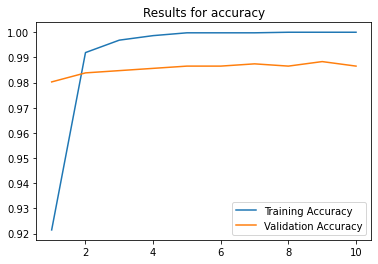

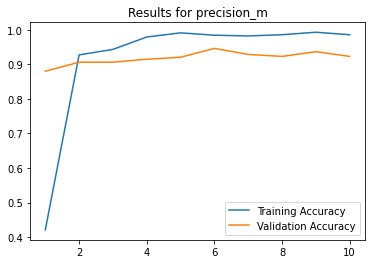

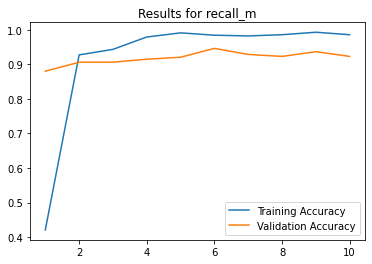

In [48]:
# Plot the evaluation metrics for each epoch of the model to check the model performance...
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = modelFit.history[i]
    val_acc = modelFit.history['val_{}'.format(i)]
    epochs = range(1, len(acc)+1)

    # plot the graphs...
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title("Results for {}".format(i))
    plt.legend()
    plt.show()